In [1]:
# 1. Install and import Earth Engine Python API
# Uncomment the following line if running in Colab or a new environment:
# !pip install earthengine-api
%load_ext autoreload
%autoreload 2


import os
import sys
module_path = os.path.abspath(os.path.join('..', 'offshore_methane'))
if module_path not in sys.path:
    sys.path.append(module_path)


import rasterio
import ee
import geopandas as gpd
import geemap
from sunglint import add_sgi_b8a_b3, add_abascal_sun_glint_bands, print_s2_metadata_angles, expanded_into_mosaic, add_cloud_probability, plot_mosaic_scatter ,mosaic_scatter, add_sgi_b12_b3
from mbsp import compute_scaling_coefficient
from utils import *
import pandas as pd
from shapely.geometry import Polygon, Point
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import math
# ee.Authenticate()
ee.Initialize()
print('Earth Engine initialized.')


c:\Users\ebeva\AppData\Local\anaconda3\envs\methane\Lib\site-packages\geemap\conversion.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Earth Engine initialized.


### Load Infrastructure for the world

<Axes: >

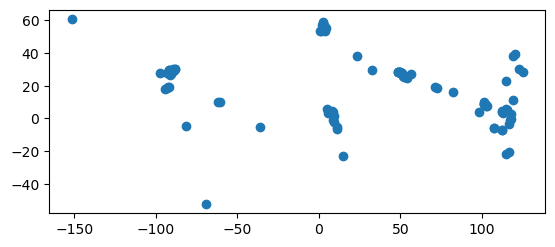

In [47]:

infra = pd.read_csv(r"C:\Users\ebeva\SkyTruth\methane\nonoise_SAR_fixed_infrastructure.csv")

# Create GeoDataFrame from infra DataFrame
infra_gdf = gpd.GeoDataFrame(
    infra,
    geometry=[Point(xy) for xy in zip(infra['lon'], infra['lat'])],
    crs="EPSG:4326"
)

# # Filter gdf by whether points are within the polygon
# gdf_gulf = gdf[gdf.geometry.within(gulf_poly)]
# gdf_gulf.plot()
infra_gdf = infra_gdf[(infra_gdf['label_confidence'] == 'high') & (infra_gdf['label'] == 'oil')]
infra_gdf_reduced = infra_gdf.sample(n=100, random_state=42)
infra_gdf_reduced.plot()

In [48]:
# Convert infra_gdf to an Earth Engine FeatureCollection of points
def gdf_to_ee_featurecollection(gdf):
    features = []
    for _, row in gdf.iterrows():
        lon, lat = row.geometry.x, row.geometry.y
        ee_point = ee.Geometry.Point([lon, lat])
        # Optionally, add properties from the row if needed
        feature = ee.Feature(ee_point, row.drop('geometry').to_dict())
        features.append(feature)
    return ee.FeatureCollection(features)

infra_fc = gdf_to_ee_featurecollection(infra_gdf)

In [49]:
infra_fc

c:\Users\ebeva\AppData\Local\anaconda3\envs\methane\Lib\site-packages\IPython\core\formatters.py:406: UserWarning: Getting info failed with: 'Request payload size exceeds the limit: 10485760 bytes.'. Falling back to string repr.
  return method()


In [50]:
def get_s2_collection(start_date, end_date, stationary_infra, cloud_percent=20):
    return (
        ee.ImageCollection('COPERNICUS/S2_SR')
        .filterDate(start_date, end_date)
        .filterBounds(stationary_infra)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_percent))
    )



In [53]:
s2 = (
    ee.ImageCollection('COPERNICUS/S2_SR')
    .filterDate('2023-01-01', '2023-12-31')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
)
s2.size()